# 🌱 Challenge : fast Partition Functions

Goal : evaluate as fast as possible 

$$Z(T) = \sum_i^N{ g_i exp\left(-\frac{E_i}{kT}\right) }$$ 

Where $E_i$ are not necessarily harmonic ; and $T$ can be extended to multiple temperatures.

Let's generate some arbitrary data:  

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h,c,k
from time import perf_counter
c_cm = c * 100 #cm.s-1

#Make dummy energy list:
N = 1000000
El_arr = np.random.rand(N)**0.5*10e4 #cm-1
El_arr.sort()  # energy levels are sorted in the energy level database
gv_arr = np.random.randint(0,10,N)
T_arr = np.arange(300,3000,10)


## Reference case 

In [16]:
def Q_ref(gv_arr, El_arr, T):
    return (gv_arr*np.exp(-h*c_cm*El_arr/(k*T))).sum()

In [17]:
t0 = perf_counter()
Q_sum = [Q_ref(gv_arr, El_arr, T) for T in T_arr]
print('SUM eval: {:.4f}s'.format(perf_counter() - t0))


SUM eval: 17.1007s


## QDM Case 

(precompute and interpolate)

2 interesting ideas here : 
- first we discretize/bin and reduce the number of exponential being evaluated
- 2nd, we can precompute parts that do not depends on the temperature. 

In [7]:

def init_w_axis(dx, log_wi, epsilon=1e-4):
    log_w_min = np.min(log_wi)
    log_w_max = np.max(log_wi) + epsilon
    N = np.ceil((log_w_max - log_w_min)/dx) + 1
    log_w_arr = log_w_min + dx * np.arange(N)
    return log_w_arr

def get_indices(arr_i, axis):
    pos    = np.interp(arr_i, axis, np.arange(axis.size))
    index  = pos.astype(int)
    return index, index + 1, pos - index

def calc_distribution(log_E, Ei, gi):
    gv0 = np.sum(gi[Ei==0.0])
    QDM = np.zeros(log_E.size)
    ni0, ni1, tEi = get_indices(np.log(Ei), log_E)
    aEi = tEi
    np.add.at(QDM, ni0, (1-aEi) * gi)
    np.add.at(QDM, ni1, aEi * gi)
    return gv0, QDM

def calc_parsum(T, log_E, QDM, gv0):
    Q = np.sum(QDM * np.exp(-h*c_cm*np.exp(log_E)/(k*T)))
    Q += gv0
    return Q


In [8]:
t0 = perf_counter()
dxE = 0.01
log_E_axis = init_w_axis(dxE, np.log(El_arr))
gv0, QDM = calc_distribution(log_E_axis, El_arr, gv_arr)
print('QDM init: {:.4f}s'.format(perf_counter() - t0))

t0 = perf_counter()
Q_qdm = [calc_parsum(T, log_E_axis, QDM, gv0) for T in T_arr]
print('QDM eval: {:.4f}s'.format(perf_counter() - t0))


QDM init: 0.5541s
QDM eval: 0.0200s


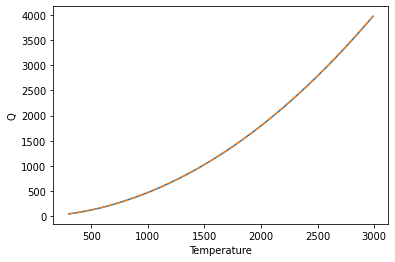

In [10]:
# Validate :
plt.figure('QDM').clear()
plt.plot(T_arr,Q_sum)
plt.plot(T_arr,Q_qdm,'--')
plt.xlabel('Temperature')
plt.ylabel('Q')
plt.show()


## Partial sums 

(sum only until convergence)

In [12]:
from numpy import abs, isclose
from numba import jit

def partial_sum(a, N=100000, rtol=0.003e-2):
    slast = 0
    s = a[:N].sum()
    i = N
    while abs(slast - s)/s > rtol and i<=len(a):
        slast = s
        s += a[i:i+N].sum()
        i += N
    # print(f"({i-N}/{len(a)} points ({(i-N)/len(a):.2%})")
    return s

def partial_sum_func(f, a, N=100000, rtol=0.003e-2):
    slast = 0
    s = f(a[:N]).sum()
    i = N
    while abs(slast - s)/s > rtol and i<=len(a):
        slast = s
        s += f(a[i:i+N]).sum()
        i += N
    # print(f"({i-N}/{len(a)} points ({(i-N)/len(a):.2%})")
    return s

def partial_sum_func_nargs(f, nargs, N=100000, rtol=0.003e-2):
    slast = 0
    s = f(*[a[:N] for a in nargs]).sum()
    i = N
    while abs(slast - s)/s > rtol and i<=len(nargs[0]):
        slast = s
        s += f(*[a[i:i+N] for a in nargs]).sum()
        i += N
    # print(f"({i-N}/{len(nargs[0])} points ({(i-N)/len(nargs[0]):.2%})")
    return s

@jit(nopython=True)
def partial_partition_sum_nargs(gv_arr, El_arr, T, N=100000, rtol=0.003e-2):
    """ same as `partial_sum_func_nargs` but with explicit parameters
    to be able to Jit it"""
    slast = 0
    s = (gv_arr[:N]*np.exp(-h*c_cm*El_arr[:N]/(k*T))).sum()
    i = N
    while abs(slast - s)/s > rtol and i<=len(gv_arr):
        slast = s
        s += (gv_arr[i:i+N]*np.exp(-h*c_cm*El_arr[i:i+N]/(k*T))).sum()
        i += N
    # print(f"({i-N}/{len(gv_arr)} points ({(i-N)/len(gv_arr):.2%})")
    return s


# Validate that partial sum formulas are right
assert isclose(partial_sum(El_arr, rtol=0), El_arr.sum())
assert isclose(partial_sum_func(lambda E: np.exp(-h*c_cm*E/(k*3000)), El_arr, rtol=0), np.exp(-h*c_cm*El_arr/(k*3000)).sum())
assert isclose(partial_sum_func_nargs(lambda g, E: g*np.exp(-h*c_cm*E/(k*3000)), (gv_arr, El_arr), rtol=0), (gv_arr*np.exp(-h*c_cm*El_arr/(k*3000))).sum())


In [20]:
t0 = perf_counter()
Q_part0 = [partial_sum_func_nargs(lambda g, E: g*np.exp(-h*c_cm*E/(k*T)), (gv_arr, El_arr), rtol=0) for T in T_arr]
print('PARTSUM (sum all) eval: {:.4f}s'.format(perf_counter() - t0), "(note it may be faster than sum : just because there is no memory saturation effect!")
rtol = 0.001 # 0.003e-2
Q_part = [partial_sum_func_nargs(lambda g, E: g*np.exp(-h*c_cm*E/(k*T)), (gv_arr, El_arr), rtol=rtol) for T in T_arr]
print('PARTSUM (rtol {:%}) eval: {:.4f}s'.format(rtol, perf_counter() - t0))

#%%
t0 = perf_counter()
rtol = 0.001 # 0.003e-2
Q_jitpart = [partial_partition_sum_nargs(gv_arr, El_arr, T, N=10000, rtol=rtol) for T in T_arr]
print('PARTSUMJIT (rtol {:%}) eval: {:.4f}s'.format(rtol, perf_counter() - t0))


PARTSUM (sum all) eval: 4.3587s (note it may be faster than sum : just because there is no memory saturation effect!
PARTSUM (rtol 0.100000%) eval: 6.2252s
PARTSUMJIT (rtol 0.100000%) eval: 0.0487s


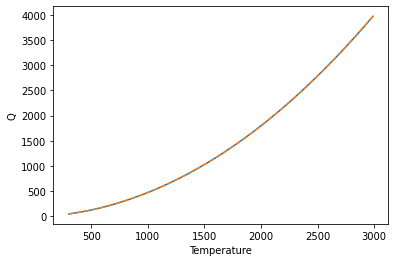

In [19]:
plt.figure('Parsum').clear()
plt.plot(T_arr,Q_sum)
plt.plot(T_arr,Q_part,'--')
plt.xlabel('Temperature')
plt.ylabel('Q')
plt.show()


## Taylor Expansion

Here: First-order Taylor Expansion (linear approximatino) with the closest neighbor on a grid.

$$exp(x) = exp(x_0) + (x-x_0) + O\left(\frac{(x-x_0)^2}{2}\right)$$

Build a grid of M elements : 

$$Z(T) = \sum_b^M{ \left( exp\left(-\frac{E_0}{kT}\right) \sum_{E_i \in [E_b, E_{b+1}]}{} g_i \right) + \left( \sum_i^N g_i \cdot \frac{E_i-E_0}{kT}  \right) }$$ 

$$Z(T) = Z_0(T) + Z_1(T)$$

Some similarities with the QDM above : 
- we reduce the number of exponentials (Z0 as one exponential per grid point ; not per level) 
- some parts can be pre-computed   (basically all of Z1 ; the only thing left at runtime is to divide by $T$ )

We can control the error made ; by increasing the Taylor expansion order. 

However, it is no match for the interpolation of the QDM, and the accuracy is very poor for grids as coarse as the one that can be used in the QDM.  

In [44]:

def init_E_grid(E, M=10000):
    return np.linspace(E.min(), E.max()+0.01, M)
    #return np.logspace(np.log10(E.min()), np.log10(E.max()+0.01), M)

def get_indices(arr_i, axis):
    pos    = np.interp(arr_i, axis, np.arange(axis.size))
    index  = pos.astype(int)
    return index, index + 1, pos - index


t0 = perf_counter()

M = 500
Egrid = init_E_grid(El_arr, M=M)


import pandas as pd
from numpy import exp
# index = np.digitize(El_arr, Egrid)
# index = np.searchsorted(Egrid, El_arr, side='left')   # equivalent
i0, i1, di = get_indices(El_arr, Egrid)
closest = i0
closest[di > 0.5 ] = i1[di > 0.5 ]
Egrid_arr = Egrid.take(closest)

# EP : a bit stupid to digitize first and groupby Egrid later. Should all be done within Vaex/Pandas.
df = pd.DataFrame({'g':gv_arr, 'E':El_arr, 'Egrid':Egrid_arr})
dgb = df.groupby('Egrid')

# sum degeneracy on grid :
g0 = dgb.g.sum().values
E0 = df.Egrid.unique()


Z0 = lambda T: (g0 * exp(-h*c_cm*E0/(k*T))).sum()

# Z1 = lambda T: (gv_arr * -h*c_cm*(El_arr-Egrid_arr)/(k*T)).sum()
Z1_precomp =(gv_arr * -h*c_cm*(El_arr-Egrid_arr)/k).sum()
Z1 = lambda T: Z1_precomp/T

print('LINEAR init: {:.4f}s'.format(perf_counter() - t0))


t0 = perf_counter()
Q_linear = [Z0(T) + Z1(T) for T in T_arr]
print('LINEAR eval: {:.4f}s'.format(perf_counter() - t0))




LINEAR init: 0.2944s
LINEAR eval: 0.0230s


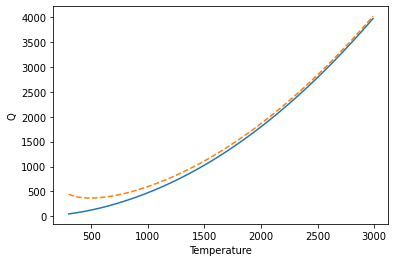

In [42]:
plt.figure("Linear").clear()
plt.plot(T_arr,Q_sum)
plt.plot(T_arr,Q_linear,'--')
plt.xlabel('Temperature')
plt.ylabel('Q')
plt.show()




## Extra

I tried to play with other interpolators, like [Laguerre Polynomials](https://en.wikipedia.org/wiki/Laguerre_polynomials) which 
are used in Gauss-Laguerre quadrature problems.

$$\int_0^\infty f(x) e^{-x} dx$$

However, the $f$ function used in a Laguerre expression proves hard to evaluate in the 
partition sum context  : it would be the sum of all levels including degeneracies on a given interval ; but the interval itself depends on 
the temperature after you evaluate $x = E_i / (kT)$

Also, the Laguerre coefficients, which could have been good candidates for a QDM-like evaluatino of the partition sum, still depend on the temperature and therefore prevents to precompute most of the calculation as done in the QDM and Taylor examples above. 